In [8]:
import torch
from matplotlib import image
import numpy
from tqdm import tqdm
from utils import * 


rgb = image.imread("euler.jpg")
lines, columns = rgb.shape[:-1]

def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))

#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 300000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1),((1-(categorical_samples//columns + torch.rand(num_samples))/lines)).unsqueeze(-1)], dim = -1)

mean = torch.mean(target_samples, dim = 0)
cov = torch.cov(target_samples.T)
instrumental = torch.distributions.MultivariateNormal(mean, (cov + cov.T)/2)
proposed_samples = instrumental.sample([num_samples])

In [5]:
class BinaryClassifier(torch.nn.Module):
    def __init__(self, label_0_samples, label_1_samples, hidden_dims):
        super().__init__()
        self.label_0_samples = label_0_samples
        self.N_0 = label_0_samples.shape[0]
        self.label_1_samples = label_1_samples
        self.N_1 = label_0_samples.shape[0]
        self.p = label_0_samples.shape[-1]

        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.SiLU(), ])
        network.pop()
        self.logit_r = torch.nn.Sequential(*network)


    def loss(self,label_0_samples,label_1_samples):
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.mean(log_sigmoid(self.logit_r(label_1_samples)))-torch.mean(log_sigmoid(-self.logit_r(label_0_samples)))

    def train(self, epochs, batch_size,lr = 5e-3, weight_decay = 5e-6):
        assert self.label_0_samples.shape[0]==self.label_1_samples.shape[0], 'mismatch in number samples'
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay = weight_decay)
        if batch_size is None:
            batch_size = self.label_1_samples.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        dataset = torch.utils.data.TensorDataset(self.label_0_samples.to(device),self.label_1_samples.to(device))

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for batch in dataloader:
                optimizer.zero_grad()
                batch_loss = self.loss(batch[0],batch[1])
                batch_loss.backward()
                optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0],batch[1]) for batch in dataloader]).mean().item()
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + '; device = ' + str(device))
        self.to(torch.device('cpu'))

In [6]:
binary_classif = BinaryClassifier(proposed_samples, target_samples,[512,512,512])
binary_classif.train(100,10000,lr = 1e-3, weight_decay = 5e-6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:11<00:00,  5.51s/it, loss = 1.237206; device = cuda]


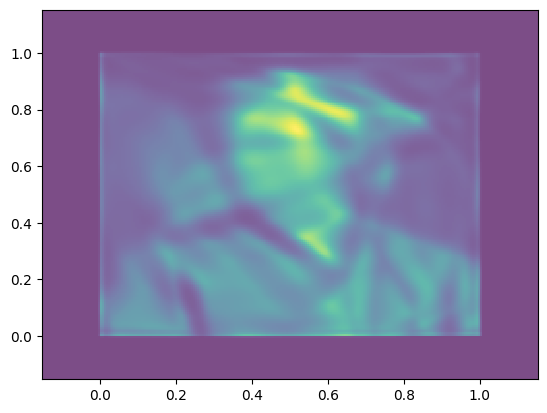

In [31]:
plot_2d_function(lambda x: torch.exp(binary_classif.logit_r(x).squeeze(-1) + instrumental.log_prob(x)), bins = (lines, columns), range =[[-0.15,1.15],[-0.15,1.15]])

In [30]:
binary_classif.train(100,10000,lr = 5e-4, weight_decay = 5e-6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:46<00:00,  7.06s/it, loss = 1.224427; device = cuda]


In [32]:
torch.save(binary_classif, 'model.sav')